In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

if os.getcwd() == '/content':
  % cd drive/MyDrive/exjobb_project

print(os.getcwd())

!pip install transformers
!pip install sentencepiece

/content/drive/MyDrive/exjobb_project
/content/drive/MyDrive/exjobb_project


In [3]:
from transformers import BertModel
from transformers import BertTokenizer
from transformers import PretrainedConfig
from transformers import XLNetModel, XLNetTokenizer

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import json
import time
import regex as re
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from collections import Counter

%matplotlib inline

In [4]:
# use an RNG seed for reproducibility
seed_list = [2, 4, 8, 16, 32]

SEED = seed_list[0]

# set the RNG seed
np.random.seed(SEED)
torch.manual_seed(SEED)

# summary of current run
summary = f'SEED: {SEED}'

In [5]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions/sessions_03_17.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

# create dictionary containing all relevant information of the symptoms
sym_info = {}

with open(f'{path_to_data}/symptoms/symptoms_03_17.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
        sym_info[sym['name']] = sym

print(f'Numer of symptoms in id2sym: {len(sym2id)}')

if False:
    # remove labels that have less than m occurrences
    m = 100

    labels_list = df['all_confirmed'].tolist()
    labels_list = sum(labels_list, [])
    c = Counter(labels_list)
    for i in range(len(df)):
        to_remove = []
        
        # find labels that should be removed 
        for j in range(len(df['all_confirmed'][i])):
            if c[df['all_confirmed'][i][j]] < m:
                to_remove.append(j)
                
        # remove the labels
        shift = 0
        for j in range(len(to_remove)):
            df['all_confirmed'][i].pop(to_remove[j]-shift)
            shift += 1

# column that should be used as labels
label_col = 'confirmed'
        
# add column with the symptom names
sym_names = []

for syms in df[label_col]:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# turn suggested column into symptom names
sym_names = []

for syms in df['suggested']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms if x in id2sym])
    else:
        sym_names.append([])

df['suggested'] = sym_names
    

# remove all rows with no confirmed labels
df = df[df[label_col].map(len) > 0]
df = df.reset_index(drop=True)

# remove unused columns
df.drop('confirmed', inplace=True, axis=1)
df.drop('all_confirmed', inplace=True, axis=1)
#df.drop('suggested', inplace=True, axis=1)

Numer of symptoms in id2sym: 479


In [6]:
# use only first limit samples
#limit = int(len(df)/4)
#limit = 400
#df = df[:limit]

print(f'Number of samples in df: {len(df)}')

if False:
    # check if there are duplicates and remove them if found
    dup_set = set()
    dup_count = 0

    for ind, row in df.iterrows():
        temp_tup = (row['text'], tuple(row['labels']))
        if temp_tup in dup_set:
            # remove text if the size is larger than 40
            #if len(row['text']) > 40:
                #print(f'Dropping index {ind} with text: {row["text"]}')
                df.drop(ind, inplace=True)
                dup_count += 1
        else:
            dup_set.add((row['text'], tuple(row['labels'])))
    df = df.reset_index(drop=True)

    print(f'Removed {dup_count} duplicates')
    print(f'Number of samples in df after removal: {len(df)}')


df.head()

Number of samples in df: 11185


,text,sex,age,suggested,labels
0,Slut på medicin.,Man,35,[Nyinsatta läkemedel],[Känd astma]
1,Jag har hostat snart 3 veckor. Snorar fram och...,Kvinna,37,"[Snuva, Hosta]","[Snuva, Hosta]"
2,Gissar att det är hasselallergi. Stora besvär ...,Man,60,"[Kissar ofta, Sveda vid miktion, Synliga hudbe...","[Tårande ögon, Synliga hudbesvär]"
3,Båda pappa och son hostar,Man,3,[Hosta],[Produktiv hosta]
4,H,Kvinna,30,[],[Hosta]


In [7]:
# choose which transformer model to use

# ELECTRA models
#path_to_model = r'./bert/electra-small-swedish-cased-discriminator'
#path_to_model = r'./bert/electra-base-swedish-cased-discriminator'

# BERT models
#path_to_model = r'./bert/bert-base-cased'
path_to_model = r'./bert/bert-base-swedish-cased'
#path_to_model = r'./bert/bert-base-multilingual-cased'

# XLNet models
#path_to_model = r'./xlnet/xlnet-base-cased'

print(f'Model path: {path_to_model}')
summary += f'\nModel path: {path_to_model}'

tok = None
if re.search(r'xlnet', path_to_model):
    tok = XLNetTokenizer.from_pretrained(path_to_model)
    print('Using XLNetTokenizer')
    summary += f'\nTokenizer: XLNetTokenizer'
elif re.search(r'bert', path_to_model):
    tok = BertTokenizer.from_pretrained(path_to_model, do_lower_case=False)
    print('Using BertTokenizer')
    summary += f'\nTokenizer: BertTokenizer'

# train a multilabel_binarizer on the labels
labels = df['labels'].tolist()
multilab_bin = MultiLabelBinarizer()
multilab_bin.fit(labels)
summary += f'\nNumber of labels: {len(multilab_bin.classes_)}'



# create a one-hot encoding of the gender
def gen2vec(cur_gen):
    gens = [0, 0, 0]
    if cur_gen == 'Kvinna':
        gens[0] = 1
    elif cur_gen == 'Man':
        gens[1] = 1
    elif cur_gen == 'Annat':
        gens[2] = 1
    else:
        print(f'UNEXPECTED OPTION FOUND: {cur_gen}')
    return gens

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, multilab_bin, max_len):
        self.tokenizer = tokenizer
        self.multilab_bin = multilab_bin
        self.data = dataframe
        self.text = self.data['text']
        self.ages = self.data['age']
        self.gens = self.data['sex']
        self.labels = self.data['labels']
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        # create a three-dimensional one-hot encoded vector to represent gender
        cur_gen = self.gens[index]
        gens = gen2vec(cur_gen)

        # represent age as float
        ages = [self.ages[index]]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'gens': torch.tensor(gens, dtype=torch.long),
            'ages': torch.tensor(ages, dtype=torch.float),
            #'labels': torch.tensor(np.sum(self.multilab_bin.transform([self.labels[index]]), axis=0), dtype=torch.float)
            'labels': torch.tensor(self.multilab_bin.transform([self.labels[index]]).reshape(-1,), dtype=torch.float)
        }        

Model path: ./bert/bert-base-swedish-cased
Using BertTokenizer


Tokenizer from ./bert/bert-base-swedish-cased


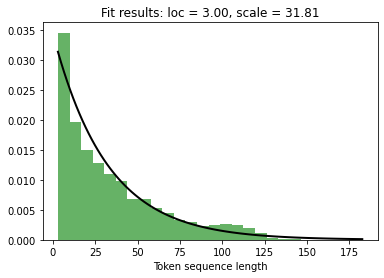

Mean = 34.81, Std = 31.81
Token sequence length including 75% of all sequences: 48
Max token sequence length: 48

Train set: 8948 samples
Test set: 2237 samples


In [23]:
#batch_size = 16
batch_size = 32
summary += f'\nBatch size: {batch_size}'


print(f'Tokenizer from {path_to_model}')


# set max number of tokens in token sequence
max_len = 0

from scipy.stats import expon
# get list of all token sequence lengths
seq_lengths = np.zeros((len(df)))

for i in range(len(df['text'])):
    text = df['text'][i]
    inputs = tok.encode_plus(
            text,
            None,
            add_special_tokens=True,
            padding=False,
            return_token_type_ids=True
            )
    
    seq_lengths[i] = len(inputs['input_ids'])

    if len(inputs['input_ids']) >= max_len and False:
        print(len(inputs['input_ids']))
        print(df['text'][i])
        print(inputs['input_ids'])
        print(tok.convert_ids_to_tokens(inputs['input_ids']))
        max_len = len(inputs['input_ids'])

# fit a normal distribution to the sequence lengths
loc, scale = expon.fit(seq_lengths)

# compute [perc]th percentile
perc = 75
max_len = int(expon.ppf(0.01*perc, loc, scale) + 1) # +1 to round up

# plot histogram of token sequence lengths
plt.hist(seq_lengths, bins=25, density=True, alpha=0.6, color='g')

# plot the PDF
xmin, xmax = plt.xlim()
x = np.linspace(loc, xmax, 100)
p = expon.pdf(x, loc, scale)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Token sequence length')
title = f'Fit results: loc = {loc:.2f}, scale = {scale:.2f}'
plt.title(title)
plt.show()

# compute mean and std of distribution
mean = expon.mean(loc, scale)
std = expon.std(loc, scale)

print(f'Mean = {mean:.2f}, Std = {std:.2f}')
print(f'Token sequence length including {perc}% of all sequences: {max_len}')

# TEMP: Manually set the max_len
#max_len = 64

print(f'Max token sequence length: {max_len}\n')
summary += f'\nMax token sequence length: {max_len}'


# tokenize the texts that describe the symptoms
sym_inputs = {}
for sym in multilab_bin.classes_:
    concat_str = sym_info[sym]['name'] + ' ' + sym_info[sym]['question'] + ' ' + sym_info[sym]['alt_name']
    
    # encode symptom descriptions into sequences of 32
    inputs = tok.encode_plus(
                concat_str,
                None,
                add_special_tokens=True,
                max_length=32,
                truncation=True,
                padding='max_length',
                return_token_type_ids=True
            )
    
    temp_ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1)
    temp_mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1)
    temp_token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1)

    if len(sym_inputs) < 1:
        sym_inputs['ids'] = temp_ids
        sym_inputs['mask'] = temp_mask
        sym_inputs['token_type_ids'] = temp_token_type_ids
    else:
        sym_inputs['ids'] = torch.cat([sym_inputs['ids'], temp_ids], dim=0)
        sym_inputs['mask'] = torch.cat([sym_inputs['mask'], temp_mask], dim=0)
        sym_inputs['token_type_ids'] = torch.cat([sym_inputs['token_type_ids'], temp_token_type_ids], dim=0)


# prepare dataloaders
train_dataset, test_dataset = train_test_split(df,
                                        test_size=0.2,
                                        shuffle=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

# - - - - TEMP - - - -
# only use a portion of the training set
#per = 0.3
#train_dataset = train_dataset[:int(per*len(train_dataset))]
# - - - - - - - - - - 

train_set = CustomDataset(train_dataset, tok, multilab_bin, max_len)
test_set = CustomDataset(test_dataset, tok, multilab_bin, max_len)

train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
               }
test_params = {'batch_size': batch_size,
               'shuffle': True,
               'num_workers': 0
              }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

print(f'Train set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

summary += f'\nTraining set: {len(train_dataset)} samples\nTest set: {len(test_dataset)} samples'

In [9]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
    summary += f'\nCUDA device: {torch.cuda.get_device_name(0)}'
else:
    dev = 'cpu'
    summary += '\nCUDA device: None'

print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

# print the device names
for i in range(torch.cuda.device_count()):
  print(f'Device {i}: {torch.cuda.get_device_name(i)}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1
Device 0: Tesla K80


In [10]:
class BERTClass(nn.Module):
    def __init__(self, config, path_to_bert, output_dim):
        super(BERTClass, self).__init__()
        #config = PretrainedConfig.from_json_file(f'{path_to_bert}/config.json')
        self.bert = BertModel.from_pretrained(path_to_bert)
        #self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size, output_dim)
        self.sigm = nn.Sigmoid()
        
    def forward(self, ids, mask, token_type_ids):
        x = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        x = self.dropout(x[1])
        x = self.fc(x)
        output = self.sigm(x)
        return output

# a BERTClass that also takes in additional features aside from text
class BERTClass_Plus(nn.Module):
    def __init__(self, config, path_to_bert, output_dim, extra_features):
        super(BERTClass_Plus, self).__init__()
        self.num_extra_features = extra_features # number of extra features
        self.bert = BertModel.from_pretrained(path_to_bert)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size+self.num_extra_features, output_dim)
        self.sigm = nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids, ages, gens):
        x = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        x = self.dropout(x[1])
        
        # add extra features through concatenation
        x = torch.cat([x,ages,gens], dim=1)

        x = self.fc(x)
        output = self.sigm(x)
        return output

# BERTClass that utilizes symptom descriptions
class BERTClass_Sym(nn.Module):
    def __init__(self, config, path_to_bert, output_dim, sym_inputs):
        super(BERTClass_Sym, self).__init__()
        self.bert = BertModel.from_pretrained(path_to_bert)
        self.hidden_size = config.hidden_size
        self.output_dim = output_dim
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(2*self.hidden_size, 1)
        self.sigm = nn.Sigmoid()

        # tensors representing the symptom descriptions
        self.sym_ids = sym_inputs['ids'].to(device)
        self.sym_mask = sym_inputs['mask'].to(device)
        self.sym_token_type_ids = sym_inputs['token_type_ids'].to(device)

    def forward(self, ids, mask, token_type_ids):
        # pass freetext descriptions to BERT
        freetext_tens = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        freetext_tens = self.dropout(freetext_tens[1])

        # pass symptom descriptions to BERT
        symptom_tens = self.bert(self.sym_ids, attention_mask=self.sym_mask,
                                 token_type_ids=self.sym_token_type_ids)
        symptom_tens = self.dropout(symptom_tens[1])

        # combine freetext outputs with the symptom description outputs
        x = torch.cat([
            freetext_tens.unsqueeze(1).expand(-1, self.output_dim, -1),
            symptom_tens.unsqueeze(0).expand(freetext_tens.shape[0], -1, -1),
        ], dim=2)
        #], dim=1)
        x = x.view(-1, 2*self.hidden_size)

        x = self.fc(x)
        x = x.view(freetext_tens.shape[0], -1)
        output = self.sigm(x)

        return output

class XLNetClass(nn.Module):
    def __init__(self, config, path_to_model, output_dim):
        super(XLNetClass, self).__init__()
        self.transformer = XLNetModel.from_pretrained(path_to_model)

        # - - - - Imitate BertPooler - - - -
        #self.dense = nn.Linear(config.d_model, config.d_model)
        #self.tanh = nn.Tanh()
        # - - - - - - - - - - - - - - - - - - -

        self.dropout = nn.Dropout(config.summary_last_dropout)

        self.fc = nn.Linear(config.d_model, output_dim)
        self.sigm = nn.Sigmoid()

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer(ids, attention_mask=mask, token_type_ids=token_type_ids)

        # - - - - Imitate BertPooler - - - -
        x = x[0][:, -1] # use the CLS token
        #x = self.dense(x)
        #x = self.tanh(x)
        # - - - - - - - - - - - - - - - - - -

        x = self.dropout(x)
        x = self.fc(x)
        output = self.sigm(x)
        return output


In [11]:
# compute the loss of an epoch by averaging all batch losses
def epoch_loss(model, data_loader, criterion):
    loss = 0
    batch_count = 0
    
    model.eval()
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            gens = batch['gens'].to(device, dtype=torch.long)
            ages = batch['ages'].to(device, dtype=torch.float)
            labels = batch['labels'].to(device, dtype=torch.float)

            # forward pass            
            outputs = model(ids, mask, token_type_ids)

            # new forward pass with extra features
            #outputs = model(ids, mask, token_type_ids, ages, gens)

            loss += criterion(outputs, labels)
            batch_count += 1
    model.train()
    return loss / batch_count

In [12]:
# define the model
D_out = len(multilab_bin.classes_)

config = PretrainedConfig.from_json_file(f'{path_to_model}/config.json')

# choose appropriate nn.module class based on pathname
model = None
if re.search(r'xlnet', path_to_model):
    model = XLNetClass(config, path_to_model, D_out)
    summary += '\nUModel class: XLNetClass'
elif re.search(r'bert', path_to_model):
    model = BERTClass(config, path_to_model, D_out)
    #model = BERTClass_Plus(config, path_to_model, D_out, 4) # BERTClass with additional features
    #model = BERTClass_Sym(config, path_to_model, D_out, sym_inputs) # BERTClass which uses symptom descriptions
    summary += '\nModel class: BertClass'

model.train()
model.to(device)

# number of epochs trained
epochs_trained = 0

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

print(summary)

SEED: 2
Model path: ./bert/bert-base-swedish-cased
Tokenizer: BertTokenizer
Number of labels: 239
Batch size: 32
Max token sequence length: 48
Training set: 8948 samples
Test set: 2237 samples
CUDA device: Tesla K80
Model class: BertClass


In [13]:

model.train()

# training loop
learning_rate = 5e-5

#learning_rate = 8e-4
#learning_rate = 1e-7

#learning_rate = 1e-5 # 1e-5 works better for bert-multilingual

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# if the test loss has not improved in the last k epochs, stop training
k = 5

num_epochs = 1000
for epoch in range(num_epochs):
    # keep track of time taken per epoch
    start_time = time.time()

    for idx,batch in enumerate(train_loader):
        ids = batch['ids'].to(device, dtype=torch.long)
        mask = batch['mask'].to(device, dtype=torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
        gens = batch['gens'].to(device, dtype=torch.long)
        ages = batch['ages'].to(device, dtype=torch.float)
        labels = batch['labels'].to(device, dtype=torch.float)

        # forward pass
        outputs = model(ids, mask, token_type_ids)

        # new forward pass with extra features
        #outputs = model(ids, mask, token_type_ids, ages, gens)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # save the losses
    train_losses.append(epoch_loss(model, train_loader, criterion))
    test_losses.append(epoch_loss(model, test_loader, criterion))

    epochs_trained += 1
    
    print(f'End of epoch {epochs_trained}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}, Time elapsed: {time.time()-start_time:.2f} s')

    # if the test loss has not improved in the last k epochs break
    if len(test_losses) > k and all(test_losses[-(k+1)] < tl for tl in test_losses[-k:]):
      print(f'Test loss has not improved in the last {k} epochs. Stopping ...')
      break

End of epoch 1, Train Loss: 0.0360741, Test Loss: 0.0361457, Time elapsed: 223.48 s
End of epoch 2, Train Loss: 0.0319126, Test Loss: 0.0319908, Time elapsed: 222.87 s
End of epoch 3, Train Loss: 0.0310643, Test Loss: 0.0311672, Time elapsed: 222.94 s
End of epoch 4, Train Loss: 0.0307702, Test Loss: 0.0308582, Time elapsed: 222.68 s
End of epoch 5, Train Loss: 0.0294625, Test Loss: 0.0296012, Time elapsed: 222.23 s
End of epoch 6, Train Loss: 0.0249237, Test Loss: 0.0252789, Time elapsed: 222.44 s
End of epoch 7, Train Loss: 0.0207595, Test Loss: 0.0215362, Time elapsed: 222.66 s
End of epoch 8, Train Loss: 0.0178884, Test Loss: 0.0193230, Time elapsed: 222.81 s
End of epoch 9, Train Loss: 0.0153626, Test Loss: 0.0177623, Time elapsed: 223.27 s
End of epoch 10, Train Loss: 0.0136494, Test Loss: 0.0170876, Time elapsed: 223.27 s
End of epoch 11, Train Loss: 0.0120694, Test Loss: 0.0163495, Time elapsed: 223.19 s
End of epoch 12, Train Loss: 0.0109289, Test Loss: 0.0163045, Time elapsed

In [ ]:
# get the predicitons and corresponding labels
def get_pred_true(model, data_loader, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
  
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            
            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)
            
    return y_pred[1:,:], y_true[1:,:]

# get the predictions, labels, and matches
def get_pred_true_match(model, dataset, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
    y_match = np.zeros((1,D_out))

    with torch.no_grad():
        for i in range(len(dataset)):
            text = str(dataset['text'][i])
            text = ' '.join(text.split())
            
            inputs = tok.encode_plus(
                text,
                None,
                add_special_tokens=True,
                max_length=max_len,
                truncation=True,
                padding='max_length',
                return_token_type_ids=True
            )

            ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1).to(device)
            mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1).to(device)
            token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1).to(device)
            
            gens = torch.tensor(gen2vec(dataset['sex'][i]), dtype=torch.long).view(1,-1).to(device)
            ages = torch.tensor([dataset['age'][i]], dtype=torch.float).view(1,-1).to(device)
            
            # forward pass
            outputs = model(ids, mask, token_type_ids)

            # new forward pass with extra features
            #outputs = model(ids, mask, token_type_ids, ages, gens)

            # get the labels
            labels = dataset['labels'][i]
            labels = np.array(multilab_bin.transform([labels]))

            # get the matches
            # matches = [id2sym[x] for x in dataset['suggested'][i] if x in id2sym]
            matches = dataset['suggested'][i]
            matches = np.array(multilab_bin.transform([matches]))

            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true, labels), axis=0)
            y_match = np.concatenate((y_match, matches), axis=0)
            
    print(y_true.shape)
    return y_pred[1:,:], y_true[1:,:], y_match[1:,:]

model.eval()  
#y_pred_temp, y_true = get_pred_true(model, test_loader, D_out)
y_pred_temp, y_true, y_match = get_pred_true_match(model, test_dataset, D_out)

SEED: 2
./bert/bert-base-swedish-cased
Number of labels in training set: 232/239 (97.07 %)
Number of labels in test set: 180/239 (75.31 %)
Number of labels present in both sets: 173/239 (72.38 %)

Micro-average F1-score: 0.678770131771596
Weighted-average F1-score: 0.6411352678102311
Macro-average F1-score: 0.4132696826749042
Accuracy (exact match): 0.4532856504246759
Hamming Loss: 0.004103672918190269

Matching system metrics:
Micro-average F1-score: 0.34135236571709837
Weighted-average F1-score: 0.6071594966917587
Macro-average F1-score: 0.45402375089065045
Accuracy (exact match): 0.2829682610639249
Hamming Loss: 0.020022706740759722


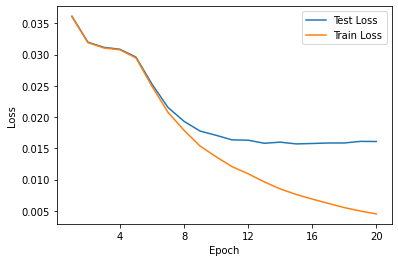

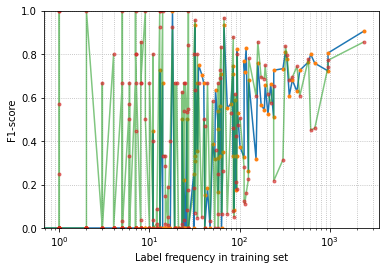

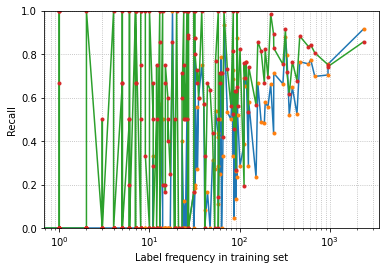

In [22]:
# set all values above threshold to 1, else 0
th = 0.5
y_pred = np.copy(y_pred_temp)
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

# TEMPORARY: remove all guesses for 'Hudbesvär' to get comparable results to match
#rem_idx = -1
#for i in range(len(multilab_bin.classes_)):
#    if multilab_bin.classes_[i] == 'Hudbesvär':
#        rem_idx = i
#y_pred[:,rem_idx] = 0

# number of labels in test set
#labels_in_test = np.count_nonzero(np.sum(y_true, axis=0))
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)
labels_in_test = np.count_nonzero(label_counts_test)

# number of labels in train set
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
labels_in_train = np.count_nonzero(label_counts_train)

# compute size of intersection between labels in train and test
label_counts_test[label_counts_test > 0] = 1
labels_bin_test = label_counts_test

label_counts_train[label_counts_train > 0] = 1
labels_bin_train = label_counts_train

labels_bin_sum = labels_bin_test + labels_bin_train
labels_intersect = np.count_nonzero(labels_bin_sum[labels_bin_sum == 2])

print(f'SEED: {SEED}')
print(path_to_model)
print(f'Number of labels in training set: {labels_in_train}/{y_true.shape[1]} ({labels_in_train/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels in test set: {labels_in_test}/{y_true.shape[1]} ({labels_in_test/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels present in both sets: {labels_intersect}/{y_true.shape[1]} ({labels_intersect/y_true.shape[1]*100:.2f} %)')
print()
print(f"Micro-average F1-score: {f1_score(y_true, y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_pred, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")

print('\nMatching system metrics:')
print(f"Micro-average F1-score: {f1_score(y_true, y_match, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_match, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_match, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_match)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_match)}")

x = [x for x in range(1,len(train_losses)+1)]
xticks = [x*len(train_losses)//5 for x in range(1,6)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(xticks,xticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot f1-score in relation to label frequency in training set
f1_per_label = f1_score(y_true, y_pred, average=None, zero_division=0)
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)

# plot f1-score for the matching system
f1_per_label_match = f1_score(y_true, y_match, average=None, zero_division=0)

# also plot recall in relation to label frequency in training set
recall_per_label = recall_score(y_true, y_pred, average=None, zero_division=0)

# and recall per label for the matching algorithm
recall_per_label_match = recall_score(y_true, y_match, average=None, zero_division=0)

# only include labels that are present in the test set
zipped = [(f1_per_label[i], f1_per_label_match[i], recall_per_label[i], recall_per_label_match[i], multilab_bin.classes_[i], label_counts_test[i], label_counts_train[i]) for i in range(len(label_counts_test)) if label_counts_test[i] > 0]
zipped = sorted(zipped, key=lambda tup: tup[-1])

f1_per_label = [zipped[i][0] for i in range(len(zipped))]
f1_per_label_match = [zipped[i][1] for i in range(len(zipped))]
recall_per_label = [zipped[i][2] for i in range(len(zipped))]
recall_per_label_match = [zipped[i][3] for i in range(len(zipped))]
label_counts_train = [zipped[i][-1] for i in range(len(zipped))]

# plot f1-score in relation to label frequency in training set
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(label_counts_train, f1_per_label)
plt.plot(label_counts_train, f1_per_label, '.')
plt.plot(label_counts_train, f1_per_label_match, alpha=0.6)
plt.plot(label_counts_train, f1_per_label_match, '.', alpha=0.6)
ax.set_xscale('log')
ax.set_ylim((0,1))
#ax.set_xlim((50,3000))
plt.xlabel('Label frequency in training set')
plt.ylabel('F1-score')
plt.grid(True, which='both', linestyle=':')
plt.show()

# plot recall in relation to label frequency in training set
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(label_counts_train, recall_per_label)
plt.plot(label_counts_train, recall_per_label, '.')
plt.plot(label_counts_train, recall_per_label_match)
plt.plot(label_counts_train, recall_per_label_match, '.')
ax.set_xscale('log')
ax.set_ylim((0,1))
plt.xlabel('Label frequency in training set')
plt.ylabel('Recall')
plt.grid(True, which='both', linestyle=':')
plt.show()

In [16]:
# write custom text for testing out the model
if False:
    text = ''

    inputs = tok.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1).to(device)
    token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1).to(device)

    # get the prediction
    y_pred_row = model(ids, mask, token_type_ids).detach().cpu()

    y_pred_row[y_pred_row > th] = 1
    y_pred_row[y_pred_row <= th] = 0

    # print symptoms
    print(multilab_bin.inverse_transform(y_pred_row))

In [17]:
model.eval()

# get a list of tuples containing the samples sorted by loss
sorted_samples = []

for i in range(len(test_dataset)):
    text = str(test_dataset['text'][i])
    text = ' '.join(text.split())

    inputs = tok.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1).to(device)
    token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1).to(device)
    
    gens = torch.tensor(gen2vec(test_dataset['sex'][i]), dtype=torch.long).view(1,-1).to(device)
    ages = torch.tensor([test_dataset['age'][i]], dtype=torch.float).view(1,-1).to(device)
    
    # get the prediction
    y_pred_row = model(ids, mask, token_type_ids).detach().cpu()

    # new forward pass with extra features
    #y_pred_row = model(ids, mask, token_type_ids, ages, gens).detach().cpu()


    # get the true labels
    y_true_row = torch.tensor(multilab_bin.transform([test_dataset['labels'][i]]), dtype=torch.float)

    # get the loss
    loss = criterion(y_pred_row, y_true_row)

    # convert predictions according to threshold
    y_pred_row[y_pred_row > th] = 1
    y_pred_row[y_pred_row <= th] = 0

    # get the suggested labels
    y_suggested_row = test_dataset['suggested'][i]

    sorted_samples.append((y_pred_row, y_true_row, y_suggested_row, text, loss))

# sort samples with regard to loss
sorted_samples = sorted(sorted_samples, key=lambda tup: tup[-1])

In [ ]:
# print the m percent best/worst predictions based on loss
m = 50
best_worst = 'worst'

nbr_elements = (len(test_dataset) * m) // 100

top_m = []
if best_worst == 'best':
  top_m = sorted_samples[:nbr_elements]
elif best_worst == 'worst':
  top_m = sorted_samples[len(sorted_samples)-nbr_elements:]
else:
  print('Please choose either "best" or "worst"')

for i in range(len(top_m)):
  tup = top_m[i]
  pred = multilab_bin.inverse_transform(tup[0])
  labels = multilab_bin.inverse_transform(tup[1])
  suggested = tup[2]#[id2sym[j] for j in tup[2] if j in id2sym]
  text = tup[3]
  loss = tup[-1]

  print(f'Loss: {loss}')
  print(f'{text}')
  print(f'Prediction: {pred}')
  print(f'Labels: {labels}')
  print(f'Suggested: {suggested}')
  print('- - - - - - - - - - - - - - - - - - - - - - - - -')

In [19]:
# checkout the tokenizer
max_len_temp = 20

text = 'Plants perform photosynthesis.'

inputs = tok.encode_plus(
            text,
            None,
            add_special_tokens=True,
            #max_length=max_len,
            #truncation=True,
            #padding='max_length',
            return_token_type_ids=True
        )

print(inputs['input_ids'])
print(inputs['token_type_ids'])
print(inputs['attention_mask'])
print(tok.convert_ids_to_tokens(inputs['input_ids']))

[2, 7921, 454, 674, 965, 30, 12588, 32412, 2508, 8836, 49796, 7, 3]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['[CLS]', 'Plan', '##ts', 'per', '##form', 'p', '##hot', '##osyn', '##th', '##esi', '##s', '.', '[SEP]']


In [20]:
from sklearn.model_selection import KFold

def kfold_val(folds, seed):

    # configuration options
    k_folds = folds
    num_epochs = 50
    lr = 5e-5

    criterion = torch.nn.BCELoss()

    # for fold results
    results = {}

    # set fixed random number seed for pytorch
    torch.manual_seed(seed)

    # prepare dataset
    dataset = CustomDataset(df, tok, multilab_bin, max_len)

    # define the k-fold cross validator
    # set random_state to ensure correct comparisons
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # start print
    print('- - - - - - - - - - - - - - - - - - - -')

    # k-fold cross validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

        # start time
        start_time = time.time()

        # print fold number
        print(f'FOLD {fold}')
        #print('- - - - - - - - - - - - - - - - - - - -')

        # sample elements randomly from a given list of ids, no replacement
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        # define dataloaders for training and test data for current fold
        train_loader = torch.utils.data.DataLoader(
                                                dataset,
                                                batch_size=batch_size,
                                                sampler=train_subsampler
                                                )
        test_loader = torch.utils.data.DataLoader(
                                                dataset,
                                                batch_size=batch_size,
                                                sampler=test_subsampler
                                                )
        
        # initialize the model
        model = BERTClass(config, path_to_model, D_out)
        #model = BERTClass_Plus(config, path_to_model, D_out, 4)
        model.train()
        model.to(device)

        # initialize optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        # keep track of the test loss
        test_losses = []

        # if the test loss has not improved in the last k epochs break
        k = 5

        for epoch in range(num_epochs):
            for idx,batch in enumerate(train_loader):
                ids = batch['ids'].to(device, dtype=torch.long)
                mask = batch['mask'].to(device, dtype=torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                gens = batch['gens'].to(device, dtype=torch.long)
                ages = batch['ages'].to(device, dtype=torch.float)
                labels = batch['labels'].to(device, dtype=torch.float)

                # forward pass
                outputs = model(ids, mask, token_type_ids)

                # new forward pass with extra features
                #outputs = model(ids, mask, token_type_ids, ages, gens)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # backward pass
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
            # save the losses
            test_losses.append(epoch_loss(model, test_loader, criterion))

            # if the test loss has not improved in the last k epochs break
            if len(test_losses) > k and all(test_losses[-(k+1)] < tl for tl in test_losses[-k:]):
                print(f'Test loss has not improved in the last {k} epochs. Stopping ...')
                break

        # evaluate model on test set
        model.eval()
        y_pred = np.zeros((1,D_out))
        y_true = np.zeros((1,D_out))
    
        with torch.no_grad():
            for idx,batch in enumerate(test_loader):
                ids = batch['ids'].to(device, dtype=torch.long)
                mask = batch['mask'].to(device, dtype=torch.long)
                token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
                gens = batch['gens'].to(device, dtype=torch.long)
                ages = batch['ages'].to(device, dtype=torch.float)
                labels = batch['labels'].to(device, dtype=torch.float)

                # forward pass
                outputs = model(ids, mask, token_type_ids)

                # new forward pass with extra features
                #outputs = model(ids, mask, token_type_ids, ages, gens)

                # save the new outputs
                y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
                y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)

        y_pred = y_pred[1:,:]
        y_true = y_true[1:,:]

        # use a threshold to determine predictions
        y_pred[y_pred > th] = 1
        y_pred[y_pred <= th] = 0

        # compute the metrics and save them
        micro_f1 = f1_score(y_true, y_pred, average='micro')
        results[fold] = micro_f1

        print(f'Micro-average F1: {micro_f1}')
        print(f'Time elapsed for current fold: {time.time()-start_time:.2f} s')
        print('- - - - - - - - - - - - - - - - - - - -')
    
    # print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    sum = 0
    for key, value in results.items():
        print(f'Fold {key}: {value}')
        sum += value
    print(f'Average micro-F1 = {sum/k_folds}')

#kfold_val(3, 2)